# Packages

**Objectifs**
- Tester si la régression linéaire fait mieux en prévision que le modèle Auto-régressif (expliqué par un retards d'un mois ou de p=4 mois)
- Identifier les variables qui expliquent le taux de croissance du chômage
- Expliquer l'impact des variables dans l'évolution du taux de croissance du chômage

**Démarche**
- Etablir le dataframe des résultats
- Analyser la performance prédictive des modèles : 
** Comparaison graphique des données de test et de prévision ; 
** Analyse des erreurs ; 
- Mesurer l'importance des prédicateurs
** Calcul de Mean permutation values (absolute error)
** Calcul de Mean permutation values (Deviance)
** Calcul de Shapley share
- Présentation graphique des métriques d'importances de covariables
- Test de validation des variables importantes
- Expliquer comment les covariables déterminent le taux de chômage

**Résultats et discussions**
- Durant les périodes avec des chocs macroéconomiques (surtout en 2019), la régression linéaire explique mieux la dynamique du chômage que les modèles auto-régressifs.
- Le modèle montre que le cycle économique est le principal déterminant du chômage. La hausse du crédit, de la demande et de la production réduit le chômage futur, tandis qu’une baisse du S&P 500 ou une récession (USREC) l’augmente.
- Le cycle économique est identifié principalement par USREC. Mais à force de reflechir, il doit être caractérisé aussi par les autres variables comme l'indice boursier, la consommation,etc. On suspect alors qu'il existe une certaine multicolinéarité des variables. Celà peut biaiser la régression linéaire et et envisager d'établir d'autres modèles.  
- D'ailleurs, on ne sait pas exactement comment l'augmentation de la consommation réduirait le chômage.
- Explorons alors la multicolinéarité des variables explicatives. 

In [70]:
# ==========================================
# Chargement
# ==========================================
import os
import pickle
import joblib
import numpy as np
import pandas as pd

from __future__ import annotations
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Chargement des résultats

In [71]:
# ---------- Helpers ----------
def load_any(path):
    """Charge un objet avec joblib puis pickle si besoin."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    try:
        return joblib.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

def try_read_meta(path):
    """Lit un CSV méta (Series si 1 colonne, sinon DataFrame)."""
    try:
        meta = pd.read_csv(path, index_col=0)
        if meta.shape[1] == 1:
            meta = meta.iloc[:, 0]  # Series
        return meta
    except Exception as e:
        print(f"⚠️ Impossible de lire {path} : {e}")
        return None

def safe_meta_print(meta, keys):
    """Affiche les clés demandées sans lever d'erreur si elles manquent."""
    if meta is None:
        print("⚠️ Pas de méta disponible.")
        return
    # Convertit en dict pour accès uniforme
    if isinstance(meta, pd.Series):
        d = meta.to_dict()
    elif isinstance(meta, pd.DataFrame):
        # prend la 1ère ligne si DataFrame
        d = meta.iloc[0].to_dict()
    elif isinstance(meta, dict):
        d = meta
    else:
        print(f"(info) Type de méta inattendu: {type(meta)}")
        d = {}

    print("\n--- Métadonnées AR(1) (clé: valeur) ---")
    for k in keys:
        v = d.get(k, None)
        print(f"{k}: {v}")

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

def ensure_ms_index_df(df: pd.DataFrame) -> pd.DataFrame:
    """Retourne un DataFrame trié avec un DatetimeIndex en début de mois (freq=MS)."""
    out = df.copy()
    out.index = pd.to_datetime(out.index).to_period("M").to_timestamp(how="start")
    return out.sort_index().asfreq("MS")

def ensure_features_present(df: pd.DataFrame, features: list[str], target_col: str | None = None):
    missing = [c for c in (features or []) if c not in df.columns]
    if target_col is not None and target_col not in df.columns:
        missing.append(target_col)
    if missing:
        raise ValueError(f"Colonnes manquantes dans le DataFrame: {missing}")

def make_exp_from_loaded(
    *,
    models,                 # liste de modèles déjà entraînés (un par fenêtre)
    features,               # list[str]
    train_periods,          # list[datetime-like], même longueur que models
    preprocs=None,          # list[...] ou None
    step_months: int = 12,
) -> dict:
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("'models' doit être une liste non vide.")
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("'features' doit être une liste non vide.")
    if not isinstance(train_periods, (list, tuple)) or len(train_periods) != len(models):
        raise ValueError("'train_periods' doit avoir la même longueur que 'models'.")
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("'preprocs' doit avoir la même longueur que 'models' si fourni.")

    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   int(step_months),
    }

def exp_from_linreg_bundle_no_refit(linreg_bundle: dict) -> dict:
    """
    Construit l'exp_results attendu par permutation_importance_pseudo_oos
    en réutilisant UNIQUEMENT ce qui est déjà sauvegardé dans le bundle.
    AUCUN ré-entraînement.
    """
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide (pas un dict).")

    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans le bundle (params.features).")

    # Modèles par fenêtre (doivent avoir été sauvegardés dans le bundle)
    models = linreg_bundle.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise RuntimeError(
            "Ce bundle ne contient pas la liste des modèles par fenêtre ('models'). "
            "Sans ces objets, l'importance par permutation ne peut pas être calculée "
            "sans ré-entraîner. Sauvegarde les modèles lors de l'apprentissage, puis recharge."
        )

    # Préproc par fenêtre (optionnel)
    preprocs = linreg_bundle.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' n'a pas la même longueur que 'models'.")

    # Périodes d'entraînement par fenêtre (alignement temporel)
    train_periods = linreg_bundle.get("train_fit_dates", None)
    if train_periods is None or len(train_periods) != len(models):
        raise RuntimeError("'train_fit_dates' manquant ou de longueur différente de 'models'.")

    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   12,
    }

In [72]:
# ---------- Fichiers ----------
AR1_LAST_PKL  = "AR1_last_trained_model.pkl"
AR1_LAST_META = "AR1_last_trained_model_meta.csv"
AR1_BUNDLE    = "AR1_h12_oos_bundle.pkl"

LINREG_PKL    = "linear_regression.pkl"
LINREG_META   = "linear_regression_meta.csv"

# 🔹 AR(p)
ARP_LAST_PKL  = "ARP_last_trained_model.pkl"
ARP_LAST_META = "ARP_last_trained_model_meta.csv"
ARP_BUNDLE    = "ARP_h12_oos_bundle.pkl"

In [73]:
# ============= CHARGEMENTS COMPLETS =============

print("=== Chargement AR(1) ===")
try:
    ar1_model = load_any(AR1_LAST_PKL)
    print("✅ Modèle AR(1) chargé.")
except Exception as e:
    ar1_model = None
    print(f"⚠️ Modèle AR(1) non chargé : {e}")
ar1_meta  = try_read_meta(AR1_LAST_META)

try:
    ar1_bundle = load_any(AR1_BUNDLE)
    print("✅ Bundle AR(1) chargé (OOS h=12).")
except Exception as e:
    ar1_bundle = None
    print(f"⚠️ Bundle AR(1) non chargé : {e}")

print("\n=== Chargement AR(p) ===")
try:
    arp_model = load_any(ARP_LAST_PKL)
    print("✅ Modèle AR(p) chargé.")
except Exception as e:
    arp_model = None
    print(f"⚠️ Modèle AR(p) non chargé : {e}")
arp_meta = try_read_meta(ARP_LAST_META)

try:
    arp_bundle = load_any(ARP_BUNDLE)
    print("✅ Bundle AR(p) chargé (OOS h=12).")
except Exception as e:
    arp_bundle = None
    print(f"⚠️ Bundle AR(p) non chargé : {e}")

print("\n=== Chargement Régression Linéaire ===")
try:
    linreg_bundle = load_any(LINREG_PKL)   # dict avec 'oos_predictions', 'params', etc.
    print("✅ Régression linéaire chargée.")
except Exception as e:
    linreg_bundle = None
    print(f"⚠️ Régression linéaire non chargée : {e}")
linreg_meta = try_read_meta(LINREG_META)

=== Chargement AR(1) ===
✅ Modèle AR(1) chargé.
✅ Bundle AR(1) chargé (OOS h=12).

=== Chargement AR(p) ===
✅ Modèle AR(p) chargé.
✅ Bundle AR(p) chargé (OOS h=12).

=== Chargement Régression Linéaire ===
✅ Régression linéaire chargée.


# Etablir de dataframe des résultats.

In [74]:
# =============== STANDARDISATION ===============
def standardize_oos_predictions(
    oos: pd.DataFrame,
    *,
    method_name: str | None = None,
    date_candidates=("date","dates"),
    true_candidates=("y_true","true","target","y"),
    pred_candidates=("y_pred","pred","prediction","forecast","yhat"),
) -> pd.DataFrame:
    """
    Convertit un DataFrame OOS quelconque en colonnes standardisées: (date, true, pred[, method]).
    - Ne dépend d'aucun modèle particulier.
    - Suppose que oos contient au moins une des colonnes candidates pour date/true/pred.
    """
    d = oos.copy()
    if d.index.name is not None:
        d = d.reset_index()

    cols = {c.lower(): c for c in d.columns}
    def _pick(cands):
        for k in cands:
            if k in cols:
                return cols[k]
        return None

    date_col = _pick(date_candidates)
    true_col = _pick(true_candidates)
    pred_col = _pick(pred_candidates)
    if not (date_col and true_col and pred_col):
        raise ValueError(f"Colonnes manquantes (date/true/pred) dans {d.columns.tolist()}")

    out = d[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
    out["date"] = _normalize_month_start(out["date"])
    if method_name:
        out["method"] = method_name
    return out.reset_index(drop=True)

In [75]:
def build_df_from_bundle(bundle: dict, default_method: str = "Model") -> pd.DataFrame:
    """
    Extrait/standardise 'oos_predictions' depuis un bundle générique.
    - Bundle attendu: {'oos_predictions': DataFrame, 'params': {'model': ...}, ...}
    - Aucune logique spécifique à un modèle.
    """
    if not isinstance(bundle, dict) or "oos_predictions" not in bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])
    params = bundle.get("params", {}) or {}
    method = params.get("model", default_method)
    return standardize_oos_predictions(bundle["oos_predictions"], method_name=method)

In [76]:
def assemble_long_from_bundles(*bundles: dict) -> pd.DataFrame:
    """
    Fusionne un nombre quelconque de bundles génériques en un long DataFrame homogène.
    Colonnes finales: (date, true, pred, method).
    """
    dfs = [build_df_from_bundle(b) for b in bundles if isinstance(b, dict)]
    dfs = [d for d in dfs if not d.empty]
    if not dfs:
        return pd.DataFrame(columns=["date","true","pred","method"])
    out = pd.concat(dfs, ignore_index=True)
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.dropna(subset=["date","true","pred"]).sort_values(["date","method"]).reset_index(drop=True)
    return out

In [77]:
# =================== SCORES ====================
def scores_basic(df: pd.DataFrame) -> dict[str, float]:
    """
    Calcule MAE, RMSE, R2 sur un DataFrame standardisé (date,true,pred[,method]).
    Totalement générique.
    """
    if df.empty:
        return {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
    mae  = float(mean_absolute_error(df["true"], df["pred"]))
    rmse = float(np.sqrt(mean_squared_error(df["true"], df["pred"])))
    r2   = float(r2_score(df["true"], df["pred"])) if len(df) > 1 else np.nan
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def scores_by_method_and_window(
    df_long: pd.DataFrame,
    eval_window=("1983-01-01","1989-12-31"),
    test_window=("1990-01-01","2025-12-31"),
) -> dict[str, dict[str, dict[str, float]]]:
    """
    Scores par méthode pour deux fenêtres (Validation/Test).
    N’emploie aucun modèle spécifique.
    """
    if df_long.empty:
        return {"validation": {}, "test": {}}
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"])
    e0, e1 = map(pd.Timestamp, eval_window)
    t0, t1 = map(pd.Timestamp, test_window)

    out = {"validation": {}, "test": {}}
    for m in sorted(df["method"].unique()):
        dval = df[(df["method"]==m) & (df["date"]>=e0) & (df["date"]<=e1)]
        dtes = df[(df["method"]==m) & (df["date"]>=t0) & (df["date"]<=t1)]
        out["validation"][m] = scores_basic(dval)
        out["test"][m]       = scores_basic(dtes)
    return out

In [78]:
# ============== OOS EXPANDING (générique) ==============
def oos_expanding_predict(
    *,
    y: pd.Series,
    X: pd.DataFrame | None = None,   # None = univarié ; sinon multivarié
    h: int = 12,
    min_train_n: int = 36,
    model_factory,                   # callable -> objet modèle avec fit(...) et predict(...)
    preproc_fit_fn=None,             # callable(X_train) -> (X_train_proc, prep)
    preproc_apply_fn=None,           # callable(X, prep) -> X_proc
    y_transform=None,                # callable(y) -> y_t
    y_inverse=None,                  # callable(y_t) -> y
    method_name: str = "Model",
) -> pd.DataFrame:
    """
    Moteur PSEUDO-OOS rolling-origin (expanding) **générique**.
    - Aucun modèle imposé : injecte ton modèle via `model_factory`.
    - `X` optionnel: univarié si None, multivarié sinon.
    - `preproc_fit_fn` et `preproc_apply_fn` optionnels (winsor/norm ou autre).
    - `y_transform`/`y_inverse` optionnels (différenciation, log, etc.).
    """
    # Alignement indices (MS)
    y = y.astype(float).copy()
    y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
    y = y.asfreq("MS")
    if X is not None:
        X = X.astype(float).copy()
        X.index = pd.to_datetime(X.index).to_period("M").to_timestamp(how="start")
        X = X.asfreq("MS")
        X, y = X.align(y, join="inner")

    rows = []
    last_t_end = y.index.max() - relativedelta(months=h)

    for t_end in y.index:
        if t_end > last_t_end:
            break
        y_tr = y.loc[:t_end]
        if len(y_tr) < min_train_n:
            continue

        X_tr = X.loc[:t_end] if X is not None else None
        y_tr_fit = y_transform(y_tr) if y_transform else y_tr

        if X_tr is not None and preproc_fit_fn:
            X_tr_p, prep = preproc_fit_fn(X_tr)
        else:
            X_tr_p, prep = (X_tr, None)

        model = model_factory()
        if X_tr_p is None:
            # univarié: le wrapper du modèle doit offrir .fit(y_series)
            model.fit(y_tr_fit)
        else:
            model.fit(X_tr_p, y_tr_fit.values)

        t_fore = t_end + relativedelta(months=h)
        if t_fore in y.index:
            if X is not None:
                x_fore_raw = X.loc[[t_fore]]
                x_fore_p = preproc_apply_fn(x_fore_raw, prep) if (preproc_apply_fn and prep is not None) else x_fore_raw
                yhat_h = float(model.predict(x_fore_p)[0])
            else:
                # univarié: le wrapper doit offrir predict(y_full, t_end, h)
                yhat_h = float(model.predict(y, t_end=t_end, h=h))

            if y_inverse:
                yhat_h = float(y_inverse(pd.Series([yhat_h], index=[t_fore]))[0])

            rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

    out = pd.DataFrame(rows, columns=["date","true","pred"]).sort_values("date")
    out["date"] = _normalize_month_start(out["date"])
    out["method"] = method_name
    return out.reset_index(drop=True)

In [79]:
# ========= Standardisation & fusion (générique, sans modèle spécifique) =========
available_bundles = [b for b in (ar1_bundle, arp_bundle, linreg_bundle) if isinstance(b, dict)]

if len(available_bundles) == 0:
    raise RuntimeError("Aucun bundle disponible parmi AR(1), AR(p), LinearRegression.")

# 1) DataFrame long standardisé : (date, true, pred, method)
df_pred_long = assemble_long_from_bundles(*available_bundles)

print(f"\n✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
if not df_pred_long.empty:
    print("Méthodes :", sorted(df_pred_long["method"].unique().tolist()))
    print(df_pred_long.head(10))

# 2) Évaluation (fenêtres Validation/Test)
eval_window = ("1983-01-01", "1989-12-31")
test_window = ("1990-01-01", "2025-12-31")

scores = scores_by_method_and_window(
    df_pred_long,
    eval_window=eval_window,
    test_window=test_window,
)

print("\n📊 Scores par méthode")
print("Validation", eval_window, ":", scores["validation"])
print("Test",       test_window, ":", scores["test"])


✅ Fusion réussie — df_pred_long shape = (2223, 4)
Méthodes : ['AR(1)', 'AR(p)', 'LinearRegression']
        date  true      pred            method
0 1963-12-01   0.0  0.070473             AR(1)
1 1963-12-01   0.0  0.070473             AR(p)
2 1963-12-01   0.0 -0.729972  LinearRegression
3 1964-01-01  -0.1  0.017682             AR(1)
4 1964-01-01  -0.1  0.017682             AR(p)
5 1964-01-01  -0.1 -0.234660  LinearRegression
6 1964-02-01  -0.5  0.090722             AR(1)
7 1964-02-01  -0.5  0.090722             AR(p)
8 1964-02-01  -0.5  1.067340  LinearRegression
9 1964-03-01  -0.3  0.165681             AR(1)

📊 Scores par méthode
Validation ('1983-01-01', '1989-12-31') : {'AR(1)': {'MAE': 0.8165429053887817, 'RMSE': 1.2335653335804957, 'R2': -0.948709263073934}, 'AR(p)': {'MAE': 0.8185346590982999, 'RMSE': 1.1873279642039227, 'R2': -0.8053613076628792}, 'LinearRegression': {'MAE': 0.8149037150628475, 'RMSE': 1.0237021878324808, 'R2': -0.3420540293832699}}
Test ('1990-01-01', '2025-12

In [80]:
def filter_df_by_start_date(df: pd.DataFrame, start_date: str = "1990-01-01") -> pd.DataFrame:
    """
    Filtre un DataFrame standardisé (date, true, pred, method)
    en ne gardant que les observations à partir de `start_date`.
    Retourne un DataFrame trié + index propre.
    """
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")

    out = (
        out[out["date"] >= pd.Timestamp(start_date)]
        .sort_values(["date", "method"])
        .reset_index(drop=True)
    )

    print(f"\n✅ Filtrage appliqué — période: {out['date'].min().date()} → {out['date'].max().date()} | n={len(out)}")
    print("Méthodes présentes :", sorted(out["method"].unique().tolist()))
    print("\nAperçu post-filtrage :")
    print(out.head(10))

    return out

In [81]:
df_pred_long = filter_df_by_start_date(df_pred_long, start_date="1990-01-01")


✅ Filtrage appliqué — période: 1990-01-01 → 2025-08-01 | n=1284
Méthodes présentes : ['AR(1)', 'AR(p)', 'LinearRegression']

Aperçu post-filtrage :
        date  true      pred            method
0 1990-01-01   0.0 -0.092641             AR(1)
1 1990-01-01   0.0 -0.105509             AR(p)
2 1990-01-01   0.0 -0.198600  LinearRegression
3 1990-02-01   0.1 -0.050509             AR(1)
4 1990-02-01   0.1 -0.083438             AR(p)
5 1990-02-01   0.1 -0.355812  LinearRegression
6 1990-03-01   0.2 -0.111200             AR(1)
7 1990-03-01   0.2 -0.144301             AR(p)
8 1990-03-01   0.2 -0.426362  LinearRegression
9 1990-04-01   0.2 -0.157130             AR(1)


# Analyser la performance prédictive des modèles

## Comparaison des données de test et de prévision

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_wide_from_long(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Transforme un DataFrame long (date, method, pred, true)
    en un tableau large : une colonne par méthode + la vérité.
    """
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Valeur "true" médiane par date
    true_by_date = df.groupby("date")["true"].median().rename("true")

    # Moyenne des prédictions par méthode
    wide = df.pivot_table(index="date", columns="method", values="pred", aggfunc="mean").sort_index()
    wide = wide.join(true_by_date, how="left")

    print("✅ wide prêt :", wide.shape, "| Colonnes :", wide.columns.tolist())
    return wide

In [83]:
def make_color_map(methods: list[str]) -> dict:
    """
    Crée une palette de couleurs cohérente pour chaque méthode.
    """
    cmap = {}
    base_colors = plt.cm.get_cmap("tab10", len(methods))
    for i, m in enumerate(methods):
        cmap[m] = base_colors(i)
    cmap["true"] = "white"  # la vérité en blanc (fond noir)
    return cmap

In [84]:
def get_split_dates(segments):
    """
    Extrait les dates de séparation à partir d'une liste de segments :
    [(start, end, label), ...] → liste unique et triée de dates.
    """
    dates = sorted({pd.to_datetime(start) for (start, _, _) in segments})
    return dates

In [85]:
def plot_two_global_charts(
    df_long: pd.DataFrame,
    segments: list[tuple[str, str | None, str]],
    *,
    H: int = 12,
    mode: str = "aligne",   # "aligne" ou "decale"
    save: bool = True,
    title_prefix: str = ""
):
    """
    Trace deux graphiques globaux :
    1) Prévisions des modèles
    2) Évolution des erreurs absolues
    avec les dates de séparation affichées sur les deux.
    """
    plt.style.use("dark_background")

    # --- Construction du wide ---
    wide = build_wide_from_long(df_long)
    wide = wide.dropna(subset=["true"])  # sécurité
    methods = [c for c in wide.columns if c != "true"]
    colors = make_color_map(methods)
    split_dates = get_split_dates(segments)

    # ============================================================
    # 1️⃣  Prévisions des modèles
    # ============================================================
    fig1 = plt.figure(figsize=(12, 5.2))
    plt.plot(wide.index, wide["true"], label="true", color=colors["true"], linewidth=2.2)

    for m in methods:
        if mode == "aligne":
            plt.plot(wide.index, wide[m], label=m, color=colors[m], linewidth=1.5)
        elif mode == "decale":
            plt.plot(wide.index - pd.DateOffset(months=H), wide[m], label=f"{m} (−{H}m)", color=colors[m], linewidth=1.5)
        else:
            raise ValueError("mode inconnu (utiliser 'aligne' ou 'decale')")

    # Lignes verticales (séparations)
    for d in split_dates:
        plt.axvline(d, linestyle="--", alpha=0.6)

    plt.title(f"{title_prefix}Prévisions des modèles (mode={mode}, h={H})".strip())
    plt.xlabel("Date")
    plt.ylabel("Niveau")
    plt.grid(alpha=0.3)
    plt.legend(ncols=2)
    plt.tight_layout()

    if save:
        plt.savefig("global_forecasts.png", dpi=150)
        print("💾 Figure enregistrée → global_forecasts.png")

    plt.show()

    # ============================================================
    # 2️⃣  Évolution des erreurs absolues
    # ============================================================
    errs = pd.DataFrame(
        {m: (wide["true"] - wide[m]).abs() for m in methods},
        index=wide.index
    )

    fig2 = plt.figure(figsize=(12, 5.2))
    for m in methods:
        plt.plot(errs.index, errs[m], label=f"|err| {m}", color=colors[m], linewidth=1.5)

    for d in split_dates:
        plt.axvline(d, linestyle="--", alpha=0.6)

    plt.title(f"{title_prefix}Évolution des erreurs absolues".strip())
    plt.xlabel("Date")
    plt.ylabel("|Erreur|")
    plt.grid(alpha=0.3)
    plt.legend(ncols=2)
    plt.tight_layout()

    if save:
        plt.savefig("global_errors.png", dpi=150)
        print("💾 Figure enregistrée → global_errors.png")

    plt.show()

✅ wide prêt : (428, 4) | Colonnes : ['AR(1)', 'AR(p)', 'LinearRegression', 'true']


C:\Users\Mita\AppData\Local\Temp\ipykernel_14088\358210771.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", len(methods))


💾 Figure enregistrée → global_forecasts.png


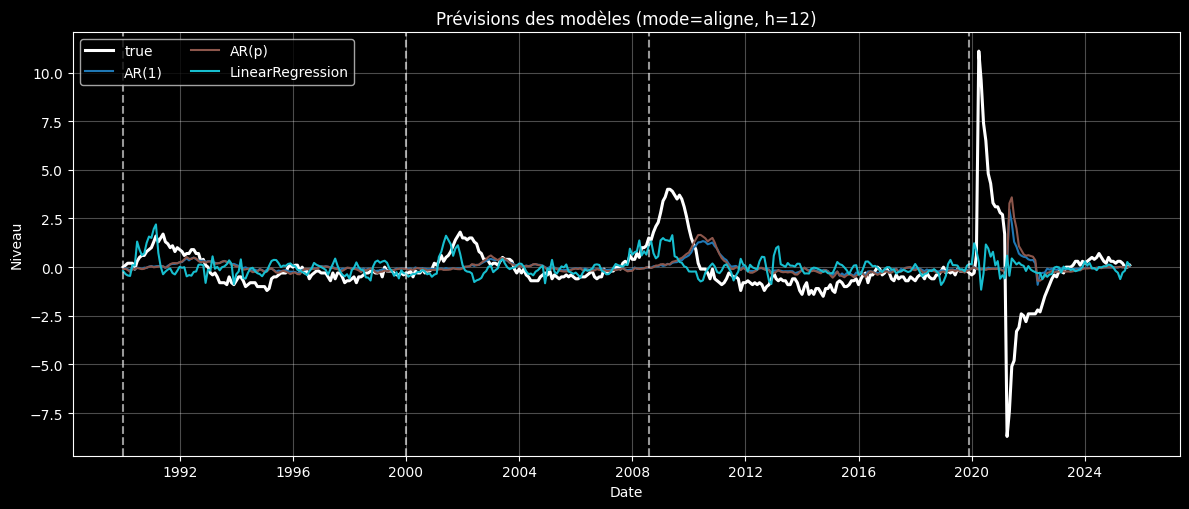

💾 Figure enregistrée → global_errors.png


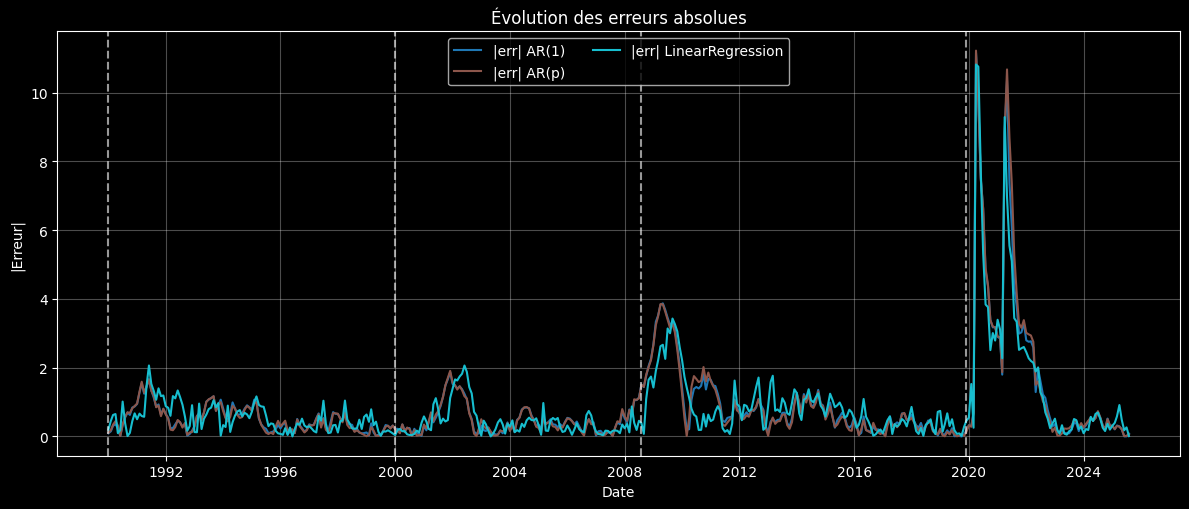

In [86]:
# Fenêtres temporelles
segments = [
    ("1990-01-01", "1999-12-31", "1990-1999"),
    ("2000-01-01", "2008-07-31", "2000-2008"),
    ("2008-08-01", "2019-11-30", "2008-2019"),
    ("2019-12-01", None,         "2019-fin"),
]

# Appel principal → produit 2 figures globales
plot_two_global_charts(
    df_pred_long,
    segments,
    H=12,
    mode="aligne",  # ou "decale"
    save=True,
    title_prefix=""
)

## Analyse des erreurs

In [87]:
import numpy as np
import pandas as pd
from typing import Iterable, Optional, Tuple, List, Dict
from math import sqrt, erf, isfinite

# ============================================================
# 0) Petits utilitaires généraux
# ============================================================

def _ensure_wide(df_wide: pd.DataFrame) -> pd.DataFrame:
    """
    - S'assure que l'index est un DatetimeIndex (ou convertit la colonne 'date' si présente)
    - Trie, vérifie la présence de 'true'
    """
    wide = df_wide.copy()
    if "date" in wide.columns:
        wide["date"] = pd.to_datetime(wide["date"], errors="coerce")
        wide = wide.set_index("date")
    if not isinstance(wide.index, pd.DatetimeIndex):
        raise ValueError("df_wide doit avoir un DatetimeIndex ou une colonne 'date' convertible en datetime.")
    wide = wide.sort_index()
    if "true" not in wide.columns:
        raise ValueError("df_wide doit contenir la colonne 'true'.")
    return wide

def _resolve_methods(wide: pd.DataFrame, methods: Optional[Iterable[str]]) -> List[str]:
    """Renvoie la liste finale des colonnes modèles à évaluer (exclut 'true')."""
    if methods is None:
        return [c for c in wide.columns if c != "true"]
    return [m for m in methods if m in wide.columns and m != "true"]

def _build_windows(
    wide: pd.DataFrame,
    periods: List[Tuple[str, Optional[str], str]],
    *,
    include_overall: bool = True,
    overall_label: str = "Ensemble",
) -> List[Tuple[pd.Timestamp, pd.Timestamp, str]]:
    """Construit la liste des fenêtres (start, end, label), avec 'Ensemble' en premier si demandé."""
    full_start, full_end = wide.index.min(), wide.index.max()
    windows: List[Tuple[pd.Timestamp, pd.Timestamp, str]] = []
    if include_overall:
        windows.append((full_start, full_end, overall_label))
    for start, end, label in periods:
        s = pd.to_datetime(start)
        e = pd.to_datetime(end) if end is not None else full_end
        windows.append((s, e, label))
    return windows

In [ ]:
# ============================================================
# 1) Calcul des MAE & erreurs par fenêtre
# ============================================================

def _mae_and_errors_for_window(
    sub: pd.DataFrame,
    methods: List[str],
    *,
    min_obs: int = 20,
) -> Tuple[Dict[str, float], Dict[str, pd.Series]]:
    """
    Renvoie:
      - maes:    {model -> MAE} (NaN si pas assez d'observations)
      - err_abs: {model -> série |true - pred| alignée sur l'index de sub}
    """
    maes: Dict[str, float] = {}
    err_abs: Dict[str, pd.Series] = {}
    for m in methods:
        diffs = (sub["true"] - sub[m]).abs()
        valid = diffs.dropna()
        err_abs[m] = valid
        maes[m] = float(valid.mean()) if valid.shape[0] >= min_obs else np.nan
    return maes, err_abs

In [89]:
# ============================================================
# 2) Test de Diebold–Mariano (version sans SciPy)
# ============================================================

def _phi(z: float) -> float:
    """CDF N(0,1)."""
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

def _dm_pvalue(diff: np.ndarray, lags: int = 0) -> float:
    """
    p-value bilatérale du test DM avec variance HAC (poids de Bartlett).
    diff = l_t = loss_model - loss_best (ici MAE via erreurs absolues).
    lags=0 : erreurs 1-step non chevauchées (cas le plus simple).
    """
    x = np.asarray(diff, dtype=float)
    x = x[np.isfinite(x)]
    T = x.size
    if T < 3:
        return np.nan

    dbar = x.mean()
    gamma0 = np.dot(x - dbar, x - dbar) / T
    var = gamma0
    if lags > 0:
        for k in range(1, min(lags, T - 1) + 1):
            w = 1.0 - k / (lags + 1.0)
            cov = np.dot(x[k:] - dbar, x[:-k] - dbar) / T
            var += 2.0 * w * cov
    if var <= 0:
        return np.nan

    stat = dbar / sqrt(var / T)
    p = 2.0 * (1.0 - _phi(abs(stat)))
    return max(0.0, min(1.0, p))

In [90]:

# ============================================================
# 3) Formatage cellule "MAE (p)" par fenêtre
# ============================================================

def _format_cells_for_window(
    sub: pd.DataFrame,
    methods: List[str],
    maes: Dict[str, float],
    err_abs: Dict[str, pd.Series],
    *,
    min_obs: int,
    add_dm: bool,
    dm_lags: int,
    show_p_for_best: bool,
    round_digits: int,
    label_map: Optional[Dict[str, str]] = None,
) -> List[Tuple[str, str]]:
    """
    Pour une fenêtre donnée, retourne une liste [(model_label, cell_text), ...]
    où cell_text = "MAE" ou "MAE (p)".
    """
    # Trouver le meilleur modèle sur la fenêtre (MAE minimale)
    finite_models = [m for m in methods if isfinite(maes.get(m, np.nan))]
    best_m = min(finite_models, key=lambda m: maes[m]) if finite_models else None

    out: List[Tuple[str, str]] = []
    for m in methods:
        label = label_map.get(m, m) if label_map else m
        mae_val = maes.get(m, np.nan)

        if not isfinite(mae_val):
            out.append((label, np.nan))
            continue

        p_txt = ""
        if add_dm and best_m is not None and m != best_m:
            # DM vs meilleur : réaligner sur dates communes
            v1 = err_abs[m]
            v2 = err_abs[best_m]
            common = v1.index.intersection(v2.index)
            diff = (v1.loc[common] - v2.loc[common]).values
            if diff.size >= min_obs:
                pval = _dm_pvalue(diff, lags=dm_lags)
                if isfinite(pval):
                    p_txt = f" ({pval:.3f})"
        elif add_dm and show_p_for_best and m == best_m:
            p_txt = " (—)"

        cell = f"{mae_val:.{round_digits}f}{p_txt}"
        out.append((label, cell))
    return out

In [91]:
# 1) Construire wide une seule fois (même logique que dans ta fonction de plot)
wide = build_wide_from_long(df_pred_long).dropna(subset=["true"])

# 2) Tes segments
segments = [
    ("1990-01-01", "1999-12-31", "1990-1999"),
    ("2000-01-01", "2008-07-31", "2000-2008"),
    ("2008-08-01", "2019-11-30", "2008-2019"),
    ("2019-12-01", None,         "2019-fin"),
]

# 3) (Optionnel) filtrer les colonnes/modèles à inclure
methods_keep = ["AR(1)", "AR(p)", "LinearRegression"]  # ou None pour tout prendre sauf 'true'

# 4) Tableau pivoté MAE depuis le wide déjà prêt
table_pivot = make_mae_pivot_from_wide(
    df_wide=wide,
    periods=segments,
    methods=methods_keep,        # ou None
    include_overall=True,
    overall_label="Ensemble",
    min_obs=20,
    round_digits=4,
)

print(table_pivot)

✅ wide prêt : (428, 4) | Colonnes : ['AR(1)', 'AR(p)', 'LinearRegression', 'true']
period                  Ensemble       1990-1999       2000-2008  \
model                                                              
AR(1)             0.8670 (0.129)  0.5078 (0.003)  0.4742 (0.327)   
AR(p)             0.8651 (0.198)          0.4951  0.4671 (0.446)   
LinearRegression          0.8317  0.5396 (0.190)          0.4390   

period                 2008-2019        2019-fin  
model                                             
AR(1)             0.8775 (0.468)  2.0573 (0.039)  
AR(p)             0.8512 (0.875)  2.1302 (0.016)  
LinearRegression          0.8433          1.9033  


## **Règle d’interprétation**

Le test de **Diebold–Mariano (DM)** vérifie si le modèle ayant le **plus petit MAE** est **significativement meilleur** que les autres.

- **Modèle sans parenthèse** → Meilleur modèle de la période.  
- **Valeur entre parenthèses** → *p-value* du test DM comparant ce modèle au meilleur.

### **Hypothèses**
- **H₀ :** Les deux modèles ont des performances **équivalentes** (pas de différence significative).  
- **H₁ :** Le meilleur modèle (MAE minimal) est **statistiquement plus performant**.

### **Interprétation des p-values**

| p-value | Signification | Conclusion |
|:--:|:--|:--|
| **p < 0.05** | Différence **significative** | Le modèle testé est **moins performant** |
| **0.05 ≤ p < 0.10** | Différence marginale | Le modèle testé est **légèrement moins bon** |
| **p ≥ 0.10** | Aucune différence significative | Les modèles sont **équivalents** |

**Résultats d'Interprétation**
- Dans les années 1990, la dynamique autorégressive plus longue (AR(p)) est la plus adaptée.

- Dans les années 2000 et après la crise, LinearRegression devient plus efficace — sans être significativement meilleure la plupart du temps.

- En période récente (post-2019), la régression linéaire surpasse clairement les modèles AR. En effet, durant ce moment de crise de Covid, le taux de chômage n'est plus expliqué par son passé, on entre dans une nouvelle structure. Avec l'aide des informations des autres variables, la régression linéaire prévoit mieux. 

- Globalement, les différences restent faibles, sauf à deux périodes clés :
    - les années 1990 (AR(p) > AR(1)),
    - la période post-2019 (LinearRegression > AR).

# Mesurer l'importance des prédicateurs

## Calcul de Mean permutation values (absolute error)

In [92]:
# ==========================================================
# IMPORTS
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [93]:
# ==========================================================
# PARTIE 1 — Helpers internes (généraux)
# ==========================================================
def _ensure_ms_index(idx_like):
    idx = pd.to_datetime(idx_like)
    return idx.to_period("M").to_timestamp(how="start")

def _rng(random_state=None):
    return np.random.default_rng(random_state)

def _validate_exp_results(exp_results: dict):
    models = exp_results.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("exp_results['models'] doit être une liste non vide.")
    features = exp_results.get("features", None)
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("exp_results['features'] doit être une liste non vide.")
    preprocs = exp_results.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("Si fourni, exp_results['preprocs'] doit avoir la même longueur que 'models'.")
    return {
        "models":   models,
        "features": list(features),
        "preprocs": preprocs,
        "train_periods": exp_results.get("train_periods", None),
        "step_months": int(exp_results.get("step_months", 12)),
    }

def _prepare_df(df_all: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df = df_all.copy()
    df.index = _ensure_ms_index(df.index)
    df = df.sort_index()
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' n'existe pas dans df_all.")
    return df

def _check_features_exist(df: pd.DataFrame, features: list[str]):
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

def _eval_window_bounds(restrict_eval_window: tuple[str, str] | None):
    if restrict_eval_window is None:
        return None, None
    return pd.Timestamp(restrict_eval_window[0]), pd.Timestamp(restrict_eval_window[1])

In [94]:
# ==========================================================
# PARTIE 2 — Fenêtrage & construction X/y
# ==========================================================
def _window_end_time(df: pd.DataFrame, i: int, train_periods, step_months: int) -> pd.Timestamp:
    if train_periods is not None:
        return pd.Timestamp(train_periods[i])
    all_times = df.index.unique().sort_values()
    end_idx = min((i + 1) * step_months, len(all_times) - 1)
    return all_times[end_idx]

def _build_X_y_for_window(df_win: pd.DataFrame, features: list[str], target_col: str, h: int):
    """Construit X_t et y_{t+h} alignés sur t (mêmes longueurs)."""
    if len(df_win) <= h:
        return None, None
    X_raw = df_win.loc[:, features].iloc[:-h].copy()
    y     = df_win.loc[:, target_col].shift(-h).iloc[:-h].copy()
    return X_raw, y

def _mask_eval_window(df_win: pd.DataFrame, y_len: int, h: int, eval_start, eval_end):
    """Masque booléen sur la date cible y_{t+h} ∈ [eval_start, eval_end]."""
    if eval_start is None or eval_end is None:
        return np.ones(y_len, dtype=bool)
    target_index = df_win.index[h : h + y_len]
    return (target_index >= eval_start) & (target_index <= eval_end)

def _mask_valid_rows(X_raw: pd.DataFrame, y: pd.Series, mask_window: np.ndarray):
    valid = ~(X_raw.isnull().any(axis=1) | y.isnull())
    valid &= mask_window
    return valid

In [95]:
# ==========================================================
# PARTIE 3 — Prétraitement & scoring
# ==========================================================
def _apply_preproc_if_any(X_raw: pd.DataFrame, preprocs, i: int, preproc_apply_fn):
    if preprocs is not None and preproc_apply_fn is not None:
        return preproc_apply_fn(X_raw, preprocs[i])
    return X_raw

def _compute_base_score(model, X_pp: pd.DataFrame, y_true: pd.Series, metric) -> float:
    yhat = model.predict(X_pp)  # garder DataFrame pour éviter les warnings de features names
    return float(metric(y_true.to_numpy(), yhat))

def _permute_feature_scores_metric(model, X_pp: pd.DataFrame, y_true: pd.Series, col: str, n_repeats: int, rng, metric) -> float:
    perms = np.empty(n_repeats, dtype=float)
    src = X_pp[col].to_numpy()
    for r in range(n_repeats):
        X_perm = X_pp.copy()
        X_perm[col] = src[rng.permutation(len(src))]
        yhat_perm = model.predict(X_perm)
        perms[r] = metric(y_true.to_numpy(), yhat_perm)
    return float(np.mean(perms))

In [96]:
# ==========================================================
# PARTIE 4 — Agrégation (patché pour gérer le cas vide)
# ==========================================================
def _aggregate_importance(var_imp: dict[str, list[float]], metric) -> pd.DataFrame:
    rows = []
    for col, ratios in var_imp.items():
        if ratios:
            rows.append({
                "variable": col,
                "perm_score_ratio_mean": float(np.mean(ratios)),
                "perm_score_ratio_std":  float(np.std(ratios)),
                "n_windows": int(len(ratios)),
                "metric": getattr(metric, "__name__", str(metric)),
            })
    if not rows:
        # ✅ évite KeyError lors de sort si vide
        return pd.DataFrame(
            columns=["variable","perm_score_ratio_mean","perm_score_ratio_std","n_windows","metric"]
        )
    return pd.DataFrame(rows).sort_values("perm_score_ratio_mean", ascending=False).reset_index(drop=True)

In [97]:
# ==========================================================
# PARTIE 5 — Orchestrateur : permutation_importance_pseudo_oos
# ==========================================================
def permutation_importance_pseudo_oos(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    n_repeats: int = 20,
    metric=mean_absolute_error,
    random_state=None,
    restrict_eval_window: tuple[str, str] | None = ("1983-01-01", "1989-12-31"),
    preproc_apply_fn=None,   # callable(X, prep) -> X_processed
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Importance par permutation en pseudo-OOS (expanding) *sans refit*.
    Retourne un DataFrame trié par importance décroissante (ratio > 1 ⇒ plus important).
    """
    cfg = _validate_exp_results(exp_results)
    models      = cfg["models"]
    features    = cfg["features"]
    preprocs    = cfg["preprocs"]
    periods     = cfg["train_periods"]
    step_months = cfg["step_months"]

    df = _prepare_df(df_all, target_col)
    _check_features_exist(df, features)

    eval_start, eval_end = _eval_window_bounds(restrict_eval_window)
    rng = _rng(random_state)

    var_imp = {col: [] for col in features}

    for i, model in enumerate(models):
        end_time = _window_end_time(df, i, periods, step_months)
        df_win = df.loc[:end_time].copy()

        X_raw, y = _build_X_y_for_window(df_win, features, target_col, h)
        if X_raw is None:
            continue

        mask_window = _mask_eval_window(df_win, len(y), h, eval_start, eval_end)
        valid = _mask_valid_rows(X_raw, y, mask_window)
        if not np.any(valid):
            continue

        X_raw = X_raw.loc[valid]
        y_use = y.loc[valid]

        X_pp = _apply_preproc_if_any(X_raw, preprocs, i, preproc_apply_fn)

        base = _compute_base_score(model, X_pp, y_use, metric)
        if not np.isfinite(base) or base == 0:
            if verbose:
                print(f"[PI] fenêtre {i:02d} — base_score non fini/0 → ignorée.")
            continue

        for col in features:
            perm_mean = _permute_feature_scores_metric(model, X_pp, y_use, col, n_repeats, rng, metric)
            var_imp[col].append(float(perm_mean / base))

        if verbose:
            print(f"[PI] fenêtre {i:02d} — obs={len(X_pp)} — base={base:.4f}")

    imp_df = _aggregate_importance(var_imp, metric)
    exp_results["permutation_importance_oos"] = imp_df  # stockage optionnel
    return imp_df

In [98]:
# ==========================================================
# PARTIE 6 — Reconstruction LR par fenêtres (unique, pas de doublon)
# ==========================================================
def rebuild_linreg_exp_from_bundle(
    df_all: pd.DataFrame,
    linreg_bundle: dict,
    *,
    target_col: str = "UNRATE",
    preproc_fit_fn=None,   # callable(X_train, wins=..., do_norm=...) -> (X_train_proc, prep)
):
    """
    Reconstruit les modèles LinearRegression pour chaque fenêtre de 'train_fit_dates'
    à partir de linreg_bundle (mêmes features / mêmes fenêtres / même préproc).
    Retourne un exp_results dict compatible avec permutation_importance_pseudo_oos.
    """
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide.")

    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans linreg_bundle['params']['features'].")

    train_ends = linreg_bundle.get("train_fit_dates", None)
    if train_ends is None or len(train_ends) == 0:
        raise ValueError("'train_fit_dates' absent dans linreg_bundle.")

    winsor_level = float(params.get("winsor_level", 0.01))
    norm_var     = bool(params.get("norm_var", True))
    min_train_n  = int(params.get("min_train_n", 36))
    h            = int(params.get("horizon", 12))

    df = df_all.copy()
    df.index = pd.to_datetime(df.index).to_period("M").to_timestamp(how="start")
    df = df.sort_index()

    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' manquant dans df_all.")
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

    models, preprocs, periods = [], [], []
    for t_end in pd.to_datetime(pd.Index(train_ends)):
        df_win = df.loc[:t_end]
        if len(df_win) <= max(min_train_n, h + 1):
            continue

        X_tr = df_win[features]
        y_tr = df_win[target_col]

        if preproc_fit_fn is not None:
            X_tr_p, prep = preproc_fit_fn(X_tr, wins=winsor_level, do_norm=norm_var)
        else:
            X_tr_p, prep = X_tr, None

        model = LinearRegression()
        model.fit(X_tr_p, y_tr.values)

        models.append(model)
        preprocs.append(prep)
        periods.append(t_end)

    if not models:
        raise RuntimeError("Aucun modèle LR reconstruit (fenêtres trop courtes ?).")

    exp_lin = {
        "models": models,
        "features": list(features),
        "preprocs": preprocs if any(p is not None for p in preprocs) else None,
        "train_periods": periods,
        "step_months": 12,
        "horizon": h,
        "min_train_n": min_train_n,
        "winsor_level": winsor_level,
        "norm_var": norm_var,
    }
    return exp_lin

In [99]:
def apply_preproc(X, prep):
    """Applique le préproc appris (pas de fuite)."""
    Xp = X.clip(lower=prep["lower"], upper=prep["upper"], axis=1)
    if prep["norm"]:
        Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
    return Xp

In [100]:
# ==========================================================
# ⚙️ Post-entrainement : Importance par permutation
# ==========================================================
from sklearn.metrics import mean_absolute_error

# 1️⃣ Charger le bundle
linreg_bundle = load_any("linear_regression.pkl")

# 2️⃣ Vérifier le contenu (tu l’as déjà fait, parfait)
print("📦 Contenu du bundle :", list(linreg_bundle.keys()))

# 3️⃣ Charger ton dataset de test
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = (
    pd.to_datetime(df_stationary_test.index)
      .to_period("M")
      .to_timestamp(how="start")
)
df_stationary_test = df_stationary_test.sort_index()

# 4️⃣ Reconstruire un dict exp_results directement depuis le bundle
exp_lin = {
    "models": linreg_bundle["models"],
    "features": linreg_bundle["params"]["features"],
    "preprocs": linreg_bundle.get("preprocs", None),
    "train_periods": linreg_bundle["train_fit_dates"],
    "step_months": 12,
}

# 5️⃣ Calcul de l’importance par permutation sur la période de test
imp_lin = permutation_importance_pseudo_oos(
    exp_results=exp_lin,
    df_all=df_stationary_test,
    target_col="UNRATE",
    h=linreg_bundle["params"].get("horizon", 12),
    n_repeats=20,
    metric=mean_absolute_error,
    random_state=42,
    restrict_eval_window=("1990-01-01", "2025-12-31"),  # période test
    preproc_apply_fn=apply_preproc,  # même prétraitement que dans le fit
    verbose=True,
)

print("\n✅ Importance par permutation — LinearRegression (top 10)")
print(imp_lin.head(10))

📦 Contenu du bundle : ['oos_predictions', 'params', 'meta', 'train_fit_dates', 'models', 'preprocs']
[PI] fenêtre 336 — obs=1 — base=1.1099
[PI] fenêtre 337 — obs=2 — base=1.1653
[PI] fenêtre 338 — obs=3 — base=1.3326
[PI] fenêtre 339 — obs=4 — base=1.5206
[PI] fenêtre 340 — obs=5 — base=1.5706
[PI] fenêtre 341 — obs=6 — base=1.5536
[PI] fenêtre 342 — obs=7 — base=1.5548
[PI] fenêtre 343 — obs=8 — base=1.3597
[PI] fenêtre 344 — obs=9 — base=1.2310
[PI] fenêtre 345 — obs=10 — base=1.1325
[PI] fenêtre 346 — obs=11 — base=1.0528
[PI] fenêtre 347 — obs=12 — base=0.9918
[PI] fenêtre 348 — obs=13 — base=0.9342
[PI] fenêtre 349 — obs=14 — base=0.9020
[PI] fenêtre 350 — obs=15 — base=0.9058
[PI] fenêtre 351 — obs=16 — base=0.9371
[PI] fenêtre 352 — obs=17 — base=0.8834
[PI] fenêtre 353 — obs=18 — base=0.8526
[PI] fenêtre 354 — obs=19 — base=0.8607
[PI] fenêtre 355 — obs=20 — base=0.8654
[PI] fenêtre 356 — obs=21 — base=0.8570
[PI] fenêtre 357 — obs=22 — base=0.8464
[PI] fenêtre 358 — obs=23 — 

## Calcul de Mean permutation values (Deviance)

In [121]:
# --- 1) Définir la "deviance" (ici: MSE) ---
import numpy as np

def deviance_mse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return np.mean((y_true - y_pred) ** 2)

In [122]:
# --- 2) Importance par permutation avec la deviance ---
imp_lin_dev = permutation_importance_pseudo_oos(
    exp_results=exp_lin,
    df_all=df_stationary_test,
    target_col="UNRATE",
    h=linreg_bundle["params"].get("horizon", 12),
    n_repeats=20,
    metric=deviance_mse,                  # ✅ deviance
    random_state=42,
    restrict_eval_window=("1990-01-01", "2025-12-31"),
    preproc_apply_fn=apply_preproc,
    verbose=True,
)

[PI] fenêtre 336 — obs=1 — base=1.2318
[PI] fenêtre 337 — obs=2 — base=1.3616
[PI] fenêtre 338 — obs=3 — base=1.8364
[PI] fenêtre 339 — obs=4 — base=2.4649
[PI] fenêtre 340 — obs=5 — base=2.5994
[PI] fenêtre 341 — obs=6 — base=2.5286
[PI] fenêtre 342 — obs=7 — base=2.5169
[PI] fenêtre 343 — obs=8 — base=2.1848
[PI] fenêtre 344 — obs=9 — base=1.9276
[PI] fenêtre 345 — obs=10 — base=1.7290
[PI] fenêtre 346 — obs=11 — base=1.5633
[PI] fenêtre 347 — obs=12 — base=1.4330
[PI] fenêtre 348 — obs=13 — base=1.3160
[PI] fenêtre 349 — obs=14 — base=1.2338
[PI] fenêtre 350 — obs=15 — base=1.2088
[PI] fenêtre 351 — obs=16 — base=1.2593
[PI] fenêtre 352 — obs=17 — base=1.1788
[PI] fenêtre 353 — obs=18 — base=1.1147
[PI] fenêtre 354 — obs=19 — base=1.1092
[PI] fenêtre 355 — obs=20 — base=1.0963
[PI] fenêtre 356 — obs=21 — base=1.0637
[PI] fenêtre 357 — obs=22 — base=1.0319
[PI] fenêtre 358 — obs=23 — base=0.9938
[PI] fenêtre 359 — obs=24 — base=0.9682
[PI] fenêtre 360 — obs=25 — base=0.9369
[PI] fenê

## Calcul de Shapley share

In [112]:
def _apply_preproc_general(X: pd.DataFrame, prep: dict | None) -> pd.DataFrame:
    if prep is None:
        return X
    Xp = X.copy()

    lower = prep.get("lower_wins", prep.get("lower", None))
    upper = prep.get("upper_wins", prep.get("upper", None))
    if lower is not None and upper is not None:
        # s'assurer de l'alignement colonnes
        lower_s = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
        upper_s = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
        Xp = Xp.clip(lower=lower_s, upper=upper_s, axis=1)

    if prep.get("norm", False):
        mean = prep.get("mean", None)
        std  = prep.get("std",  None)
        if mean is not None and std is not None:
            mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
            std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
            Xp = (Xp - mean_s) / std_s.replace(0, 1)

    return Xp

In [113]:
def shap_importance_last_model(exp_results: dict,
                               df_all: pd.DataFrame,
                               target_col: str,
                               h: int = 12) -> pd.DataFrame:
    """
    Calcule SHAP sur la dernière fenêtre de train et renvoie un DF trié
    avec colonnes: ['feature','abs_mean','share'] (noms standardisés).
    """
    X_full, Y, model_final, prep_final, end_time_final = _build_last_train_window(
        exp_results, df_all, target_col, h
    )

    # 1) Choisir un explainer robuste selon la version/type de modèle
    explainer = None
    try:
        # shap >= 0.39 : API unifiée
        explainer = shap.Explainer(model_final, X_full)
        shap_vals = explainer(X_full)
        # Nouvel objet Explanation
        vals = getattr(shap_vals, "values", None)
        if vals is None:
            vals = np.array(shap_vals)
    except Exception:
        # Fallback vieilles versions
        try:
            explainer = shap.LinearExplainer(model_final, X_full)
            vals = explainer.shap_values(X_full)
        except Exception as e:
            raise RuntimeError(f"Impossible de calculer les SHAP : {e}")

    vals = np.array(vals)
    if vals.ndim == 3:   # multi-output → prendre 1er output
        vals = vals[0]
    if vals.shape[1] != X_full.shape[1]:
        raise ValueError("Mismatch dimensions SHAP vs features.")

    # 2) Importance moyenne absolue + part
    abs_mean = np.abs(vals).mean(axis=0)
    total = abs_mean.sum()
    share = abs_mean / total if total > 0 else abs_mean

    shap_df = pd.DataFrame({
        "feature": X_full.columns,
        "abs_mean": abs_mean,
        "share": share
    }).sort_values("abs_mean", ascending=False).reset_index(drop=True)

    return shap_df

In [117]:
shap_df = shap_importance_last_model(
    exp_results=exp_lin,
    df_all=df_stationary_test,
    target_col="UNRATE",
    h=linreg_bundle["params"].get("horizon", 12),
)

# Présentation graphique des métriques d'importances de covariables

In [118]:
# ============================================
# FIGURE "Shapley / Permutation importance"
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Optional, Iterable

# ⚙️ PATCH : _normalize_shap accepte Series OU DataFrame
def _normalize_shap(shap_obj: pd.DataFrame | pd.Series) -> pd.Series:
    """
    Retourne une série normalisée (somme = 1) des importances SHAP.
    - Series: index=features, values=importance
    - DataFrame: doit contenir l'une des colonnes candidates, et éventuellement 'feature'
    """
    # Cas 1 : déjà une Series
    if isinstance(shap_obj, pd.Series):
        s = shap_obj.astype(float)
        tot = s.sum()
        return s / tot if tot > 0 else s

    # Cas 2 : DataFrame
    if isinstance(shap_obj, pd.DataFrame):
        df = shap_obj.copy()
        if "feature" in df.columns and df.index.name != "feature":
            df = df.set_index("feature")

        candidates = ["share", "value", "abs_mean", "mean_abs_shap", "importance", "shap"]
        for col in candidates:
            if col in df.columns:
                s = df[col].astype(float)
                tot = s.sum()
                return s / tot if tot > 0 else s

        raise ValueError(
            "shap_df doit être une Series ou un DataFrame contenant l'une des colonnes "
            + ", ".join(candidates)
        )

    # Autres types
    raise TypeError("shap_obj doit être une pandas Series ou DataFrame.")

def _prep_perm_df(imp_df: pd.DataFrame) -> pd.DataFrame:
    """
    Met en forme une importance par permutation issue de ta fonction:
      colonnes attendues: ['variable','perm_score_ratio_mean','perm_score_ratio_std'].
    Renvoie un DF indexé par variable avec colonnes 'mean' et 'std'.
    """
    need = {"variable", "perm_score_ratio_mean"}
    if not need.issubset(imp_df.columns):
        raise ValueError("imp_df doit contenir 'variable' et 'perm_score_ratio_mean'.")
    out = imp_df[["variable", "perm_score_ratio_mean"]].copy()
    out = out.rename(columns={"perm_score_ratio_mean": "mean"})
    if "perm_score_ratio_std" in imp_df.columns:
        out["std"] = imp_df["perm_score_ratio_std"].values
    else:
        out["std"] = np.nan
    return out.set_index("variable")

def _unify_feature_axis(
    shapleys: Optional[Dict[str, pd.DataFrame]],
    perm_abs: Optional[Dict[str, pd.DataFrame]],
    perm_dev: Optional[Dict[str, pd.DataFrame]],
    top_k: Optional[int]
) -> Iterable[str]:
    """
    Construit la liste finale des features (ordre commun) en fusionnant ce qui est dispo,
    triée par importance moyenne (shapley si dispo, sinon permutation absolute).
    """
    # Collecte toutes les features
    features = set()
    if shapleys:
        for m, df in shapleys.items():
            s = _normalize_shap(df)
            features.update(s.index.tolist())
    if perm_abs:
        for m, df in perm_abs.items():
            p = _prep_perm_df(df)
            features.update(p.index.tolist())
    if perm_dev:
        for m, df in perm_dev.items():
            p = _prep_perm_df(df)
            features.update(p.index.tolist())

    if not features:
        return []

    # Score moyen pour trier (priorité shapley)
    score = pd.Series(0.0, index=sorted(features))
    n = pd.Series(0, index=score.index)

    if shapleys:
        for df in shapleys.values():
            s = _normalize_shap(df).reindex(score.index).fillna(0.0)
            score += s
            n += (s > 0).astype(int)

    # Si pas de shapley, utiliser perm_abs mean (ratio >1 ⇒ +important)
    if (n == 0).all() and perm_abs:
        for df in perm_abs.values():
            p = _prep_perm_df(df).reindex(score.index)
            s = p["mean"].fillna(0.0)
            score += s
            n += (s > 0).astype(int)

    # éviter division 0
    n = n.replace(0, 1)
    score = score / n
    order = score.sort_values(ascending=False).index.tolist()
    if top_k:
        order = order[:top_k]
    return order

def _marker_palette():
    # mapping modèle → (marker, linestyle)
    return {
        "Ridge regression": ("s", "-"),
        "Random forest": ("x", "-"),
        "Gradient boosting": ("+", "-"),
        "SVR": ("*", "-"),
        "Neural network": ("^", "-"),
        # fallback (p.ex. "LinearRegression", "AR(1)", ...)
        "LinearRegression": ("s", "-"),
        "AR(1)": ("x", "-"),
        "AR(p)": ("+", "-"),
    }

def plot_importance_panels(
    *,
    shapleys: Optional[Dict[str, pd.DataFrame]] = None,   # {model_name: df or series}
    perm_abs: Optional[Dict[str, pd.DataFrame]] = None,   # {model_name: imp_df (ratio)}
    perm_dev: Optional[Dict[str, pd.DataFrame]] = None,   # idem pour deviance
    top_k: Optional[int] = None,
    figsize=(14, 4.2),
    rotate=30,
    ylabels=("Shapley share", "Mean permutation values (Absolute error)", "Mean permutation values (Deviance)")
):
    """
    Produit la figure à 3 panneaux (ceux non fournis sont ignorés).
    - shapleys : parts SHAP normalisées (ou brutes, on normalise).
    - perm_abs : importance par permutation pour MAE (ratio mean/base).
    - perm_dev : importance par permutation pour deviance (ratio mean/base).
    """
    # Déterminer l’ordre commun des features
    order = _unify_feature_axis(shapleys, perm_abs, perm_dev, top_k)
    if not order:
        raise ValueError("Aucune feature à afficher.")

    # Choisir quels panneaux activer
    panels = []
    if shapleys is not None:
        panels.append("shap")
    if perm_abs is not None:
        panels.append("perm_abs")
    if perm_dev is not None:
        panels.append("perm_dev")
    if not panels:
        raise ValueError("Fournis au moins shapleys, perm_abs ou perm_dev.")

    fig, axes = plt.subplots(1, len(panels), figsize=figsize, sharex=False)
    if len(panels) == 1:
        axes = [axes]

    markers = _marker_palette()
    model_names = set()
    if shapleys:
        model_names |= set(shapleys.keys())
    if perm_abs:
        model_names |= set(perm_abs.keys())
    if perm_dev:
        model_names |= set(perm_dev.keys())
    model_names = list(model_names)

    for ax, pane in zip(axes, panels):
        for model in model_names:
            mk, ls = markers.get(model, ("o", "-"))
            if pane == "shap" and shapleys and model in shapleys:
                s = _normalize_shap(shapleys[model]).reindex(order)
                ax.plot(order, s.values, marker=mk, linestyle="none")
            elif pane == "perm_abs" and perm_abs and model in perm_abs:
                p = _prep_perm_df(perm_abs[model]).reindex(order)
                ax.errorbar(order, p["mean"].values, yerr=p["std"].values, fmt=mk, linestyle="none", capsize=3)
            elif pane == "perm_dev" and perm_dev and model in perm_dev:
                p = _prep_perm_df(perm_dev[model]).reindex(order)
                ax.errorbar(order, p["mean"].values, yerr=p["std"].values, fmt=mk, linestyle="none", capsize=3)

        ax.set_ylabel(
            ylabels[0] if pane == "shap"
            else (ylabels[1] if pane == "perm_abs" else ylabels[2])
        )
        ax.set_xticks(range(len(order)))
        ax.set_xticklabels(order, rotation=rotate, ha="right")
        ax.grid(axis="y", linestyle=":", alpha=0.4)

    # Légende (une fois)
    handles = []
    for model in model_names:
        mk, _ = markers.get(model, ("o", "-"))
        h = plt.Line2D([], [], marker=mk, linestyle="none", label=model)
        handles.append(h)
    axes[0].legend(handles=handles, ncols=1, loc="upper right", frameon=False)

    plt.tight_layout()
    return fig

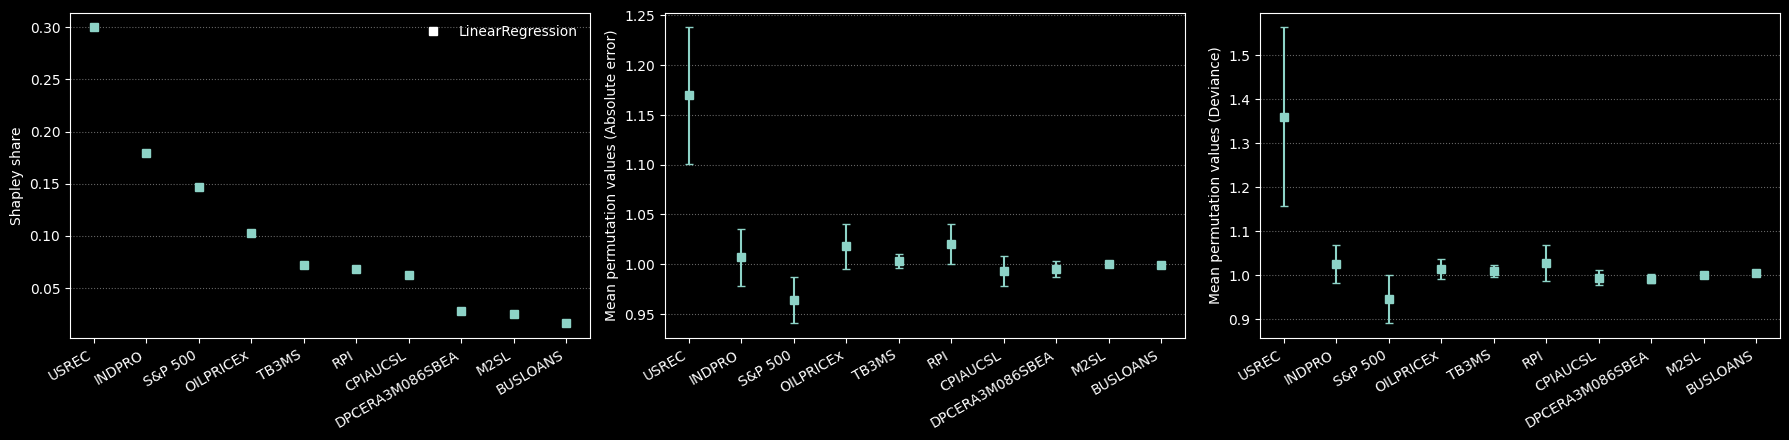

In [123]:
# --- 3) Préparer les entrées du plot ---
shap_series = shap_df.set_index("feature")["share"]
shapleys = {"LinearRegression": shap_series}
perm_abs  = {"LinearRegression": imp_lin}       # déjà calculé (MAE)
perm_dev  = {"LinearRegression": imp_lin_dev}   # nouveau (Deviance=MSE)

# --- 4) Tracer les 3 panneaux ---
fig = plot_importance_panels(
    shapleys=shapleys,
    perm_abs=perm_abs,
    perm_dev=perm_dev,           # ✅ 3e panneau
    top_k=12,
    figsize=(18, 4.5),
    rotate=30
)
plt.show()

**Règle d’interprétation**
- SHAP indique la part moyenne de chaque variable dans les prédictions.
- Permutation (MAE / Deviance) mesure la perte de performance quand on brouille une variable.
- Une variable importante combine une forte part SHAP et une hausse nette du MAE/Deviance après permutation.

**Interprétation**
- La régression linéaire explique le chômage essentiellement par le cycle économique :
    - USREC (récession) explique à hauteur de 30% à elle seule le chômage — sa permutation accroît l’erreur d’environ 20 %.
    - Les autres variables (finances, prix, monnaie, crédit) ont une influence marginale.

**Conclusion :** 
le pouvoir prédictif du modèle provient quasi exclusivement de l'indicateur cyclique : USREC. On va valider à l'aide d'un test.

# Test de validation des variables importantes

In [125]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t

def shapley_regression(
    shap_values: np.ndarray,
    y_true: np.ndarray,
    feature_names: list[str],
) -> pd.DataFrame:
    """
    Implémente la Shapley regression (Step 3 de la méthodologie).
    Régression de y_true sur les composantes SHAP pour chaque variable.

    Retourne un tableau avec :
        - β^S : coefficient de la Shapley regression
        - p-value
        - Γ^S : corrélation entre shap_i et y (orientation du signe)
    """
    # Vérifications
    if shap_values.shape[0] != len(y_true):
        raise ValueError("Dimensions incompatibles entre SHAP et y_true.")
    if shap_values.shape[1] != len(feature_names):
        raise ValueError("feature_names non alignés avec SHAP.")

    # Régression : y = α + βS * shap
    X = sm.add_constant(shap_values)
    model = sm.OLS(y_true, X).fit()

    coefs = model.params[1:]
    pvals = model.pvalues[1:]

    # Corrélation directionnelle
    corrs = [np.corrcoef(shap_values[:, i], y_true)[0, 1] for i in range(len(feature_names))]

    df = pd.DataFrame({
        "Feature": feature_names,
        "β^S": coefs,
        "p-value": pvals,
        "Γ^S": corrs
    }).sort_values("β^S", ascending=False).reset_index(drop=True)

    # Ajout des niveaux de significativité
    def stars(p):
        if p < 0.01: return "***"
        elif p < 0.05: return "**"
        elif p < 0.1: return "*"
        return ""
    df["Γ^S"] = df["Γ^S"].apply(lambda x: f"{x:+.3f}")
    df["sig"] = df["p-value"].apply(stars)
    df["Γ^S"] = df["Γ^S"] + df["sig"]
    return df

In [126]:
# Récupération des shap_values et des données finales utilisées
X_full, Y, model_final, prep_final, end_time_final = _build_last_train_window(
    exp_lin, df_stationary_test, "UNRATE", h=linreg_bundle["params"].get("horizon", 12)
)

explainer = shap.Explainer(model_final, X_full)
shap_values = explainer(X_full).values

# Lancer la Shapley regression
shap_reg_df = shapley_regression(
    shap_values=shap_values,
    y_true=Y.to_numpy(),
    feature_names=list(X_full.columns)
)

print("📊 Résultats — Shapley Regression (Linear Regression)")
display(shap_reg_df)

📊 Résultats — Shapley Regression (Linear Regression)


,Feature,β^S,p-value,Γ^S,sig
0,BUSLOANS,18.355206,0.000030,+0.223***,***
1,DPCERA3M086SBEA,4.626865,0.087848,+0.212*,*
2,USREC,0.926824,0.003011,+0.345***,***
3,TB3MS,0.636471,0.490006,+0.175,
4,INDPRO,0.217585,0.626127,+0.226,
5,OILPRICEx,0.074094,0.922059,-0.003,
6,RPI,-0.048977,0.959063,-0.124,
7,S&P 500,-0.870564,0.091282,-0.185*,*
8,CPIAUCSL,-0.875515,0.482889,-0.021,
9,M2SL,-1.270434,0.673305,-0.004,


🧩 Règle d’interprétation
- β^S ≈ 1 → effet bien capté par le modèle.
- β^S > 1 → effet sous-estimé (le modèle apprend trop faiblement cette variable).
- β^S < 1 → effet surestimé (le modèle amplifie trop la variable).
- Γ^S (corrélation SHAP–cible) : indique la direction de l’impact sur le chômage.
- p-value et étoiles (***, **, *) : significativité statistique des coefficients.

- BUSLOANS domine nettement (β^S = 18.4, p < 0.01) → effet sous-estimé et fortement lié au chômage.
- USREC et DPCERA3M086SBEA sont aussi significatifs et positivement corrélés au chômage.
- S&P 500 montre un effet négatif significatif (hausse du marché = baisse du chômage).
- Les autres variables (TB3MS, INDPRO, M2SL, CPI) sont faiblement ou non significatives.

# Explorer les relations fonctionnelles

In [136]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_shap_dependence_general(
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    features: list[str],
    h: int = 12,
    sample_frac: float = 0.3,
    random_state: int = 42,
    figsize=(10, 8)
):
    """
    Trace les relations fonctionnelles SHAP (SHAP dependence plots)
    pour les variables sélectionnées, sur la dernière fenêtre d'entraînement.
    """
    # --- 1️⃣ Reconstituer la dernière fenêtre
    X_full, Y, model_final, prep_final, end_time_final = _build_last_train_window(
        exp_results, df_all, target_col, h
    )

    # --- 2️⃣ Échantillonnage pour lisibilité
    if sample_frac < 1.0:
        X_full = X_full.sample(frac=sample_frac, random_state=random_state)
        Y = Y.loc[X_full.index]

    # --- 3️⃣ Calcul des valeurs SHAP
    explainer = shap.Explainer(model_final, X_full)
    shap_values = explainer(X_full)
    vals = getattr(shap_values, "values", np.array(shap_values))

    # --- 4️⃣ Préparer les données pour le plot
    shap_df = pd.DataFrame(vals, columns=X_full.columns, index=X_full.index)

    n_features = len(features)
    fig, axes = plt.subplots(
        nrows=n_features, ncols=1, figsize=figsize, constrained_layout=True
    )

    if n_features == 1:
        axes = [axes]

    for i, feat in enumerate(features):
        ax = axes[i]
        sns.scatterplot(
            x=X_full[feat], y=shap_df[feat],
            s=20, alpha=0.6, color="teal", ax=ax
        )
        sns.regplot(
            x=X_full[feat], y=shap_df[feat],
            scatter=False, lowess=True, color="orange", ax=ax
        )
        ax.set_xlabel("Observed values")
        ax.set_ylabel("SHAP contribution")
        ax.set_title(feat, fontsize=10)
        ax.grid(True, linestyle=":", alpha=0.4)

    fig.suptitle("Functional relationships — SHAP dependence (Linear Regression)", fontsize=12)
    plt.show()

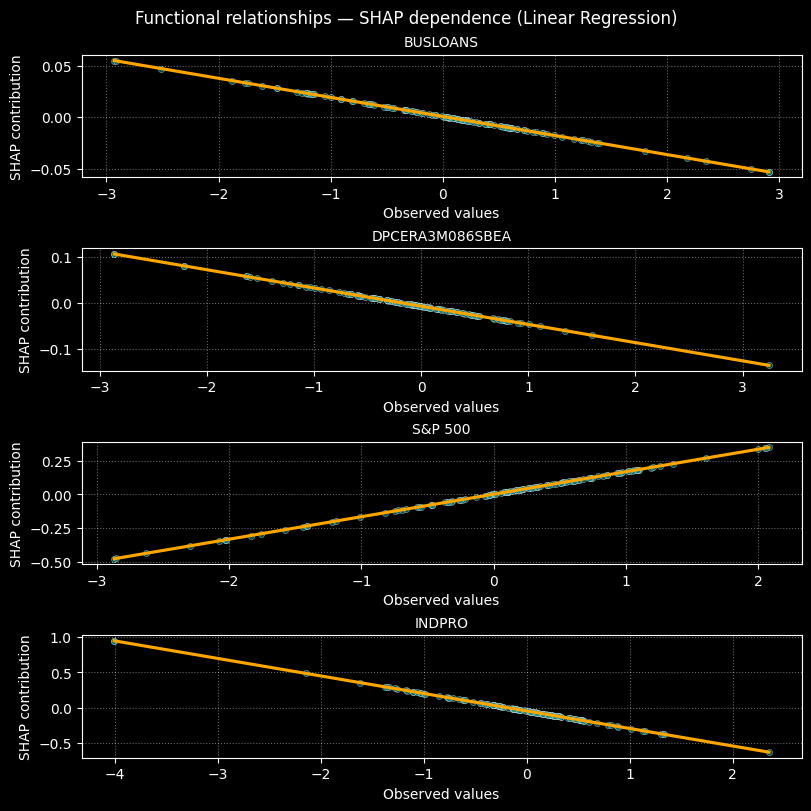

In [137]:
# ✅ 4 variables (sans USREC et sans la cible UNRATE)
key_features = ["BUSLOANS", "DPCERA3M086SBEA", "S&P 500", "INDPRO"]

# (optionnel) sécurité : retirer la cible si présente
key_features = [f for f in key_features if f != "UNRATE"]

plot_shap_dependence_general(
    exp_results=exp_lin,
    df_all=df_stationary_test,
    target_col="UNRATE",
    features=key_features,
    h=linreg_bundle["params"].get("horizon", 12),
    sample_frac=0.3,
    figsize=(8, 8)   # grille 2x2 si tu veux
)

**Apport des variables dans l'explication du chômage**
- BUSLOANS 📉 : une croissance des prêts bancaires aux entreprises, 12 mois plus tôt, favorise l’investissement et la création d’emplois → ralentit la hausse du chômage.
- DPCERA3M086SBEA 💳 : une hausse des dépenses réelles des ménages un an auparavant reflète une demande soutenue → réduit la croissance future du chômage.
- S&P 500 📈 : une baisse du marché boursier (donc une performance négative il y a 12 mois) signale un ralentissement anticipé → entraîne une hausse du chômage l’année suivante.
- INDPRO 🏭 : un recul de l’activité industrielle sur un an traduit un affaiblissement du cycle économique → se traduit par plus de chômage après 12 mois.